In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [88]:
loan_data = pd.read_csv('loan.csv', low_memory=False)
loan_data_copy = loan_data.copy()
loan_data.info()
loan_data.head()
loan_data.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [89]:
loan_data.shape

(39717, 111)

In [91]:
## capturing notebook info output of the loan data dataset 
%%capture cap --no-stderr
loan_data.info(max_cols=120)

UsageError: Line magic function `%%capture` not found.


In [ ]:
    
with open("loan_metadata.txt", 'w') as f:
    f.write(cap.stdout)

In [92]:
## to do analysis of the info output of the loan_dataset, this function will create a file with all 
## the required metadata about the loan dataset. This file will consist of missing percent of every
## single column, datatype and null or non-null object of the loan dataset
def create_meta_data_file(dataframe,filename):   

    meta_data = pd.read_csv('loan_metadata.txt', sep='\t')
    meta_data['column_name'] = meta_data.iloc[:,:].apply(lambda x:x[0].split(' ',1)[0], axis=1)
    meta_data['data_type'] = meta_data.iloc[:,:].apply(lambda x:x[0].split(' ',1)[1], axis=1)
    meta_data = meta_data.iloc[2:len(meta_data)-2,1:]
    print(meta_data.shape)

    meta_data['data_format'] = meta_data['data_type'].apply(lambda val: val.lstrip().split(' ')[2])
    meta_data['null_object_type'] = meta_data['data_type'].apply(lambda val: val.lstrip().split(' ')[1])
    meta_data['no_of_rows'] = meta_data['data_type'].apply(lambda val: val.lstrip().split(' ')[0])
    
    del meta_data['data_type']
    
    meta_data['missing_percent'] = meta_data['no_of_rows'].astype('float')/dataframe.shape[0]
    meta_data['missing_percent'] = (1-(round(meta_data['no_of_rows'].astype('float')\
                                                   /dataframe.shape[0],2)))*100
    meta_data.to_csv(filename+'.csv', index=False)

In [93]:
## this function will return the p value after performing the chi square test
from scipy import stats
def perfrom_chi_2_test(df,col1,col2):
    crosstab = pd.crosstab(loan_data[col1], loan_data[col2])
    _, p_val, _, *_ = stats.chi2_contingency(crosstab)
    print(f" P_value for chi_2 test between {col1} and {col2} {round(p_val,2)}")

In [94]:
create_meta_data_file(loan_data,'loan_metadata')

(111, 2)


In [95]:
loan_metadata = pd.read_csv('loan_metadata.csv')
loan_metadata['column_name'] = loan_metadata['column_name'].str.strip()
data_dict = pd.read_excel('Data_Dictionary.xlsx')
data_dict.rename(columns= {"LoanStatNew":"column_name"}, inplace=True)

In [96]:
data_dict.column_name = data_dict.column_name.str.strip()
data_dict.dropna(axis='index', how='any', inplace=True)

In [97]:
## merging data dictionary with the loan-metadata to generate the file with columns description, format,
## null or non-null object information and missing percent
loan_metadata_with_desc = loan_metadata.merge(data_dict, on='column_name', how='left')
loan_metadata_with_desc.to_csv('loan_metadata_with_descritption.csv', index=False)

In [98]:
## droping all the columns having missing percent greater than 90%
drop_columns_list = loan_metadata_with_desc.loc[loan_metadata_with_desc['missing_percent'] > 90,'column_name']\
.values.tolist()
loan_data.drop(axis='columns',labels=drop_columns_list,inplace=True)

In [99]:
## encoding loan status value
def map_loan_status(loan_st):
    flag = ''
    if loan_st == 'Fully Paid':
        flag = 0
    elif loan_st == 'Charged Off':
        flag = 1
    else:
        flag = 2
    return flag
    

In [100]:
## deriving different columns 

loan_data['annual_inc_derv'] = round(loan_data.annual_inc/10**3,2)
loan_data['int_rate_derv'] = loan_data.int_rate.apply(lambda int_val: float(int_val.replace('%','')))
loan_data['int_rate_amt_derv'] = loan_data['int_rate_derv']*loan_data['loan_amnt']
loan_data['is_defaulter_derv'] = loan_data.loan_status.apply(map_loan_status)
loan_data.grade = loan_data.grade.astype('category')
loan_data['grade_encoded_derv'] = loan_data.grade.cat.codes

In [101]:
## keeping only default=1 and non-default=0 observations only. Filtering all the observations where
## loan status equals current
loan_data = loan_data[(loan_data.is_defaulter_derv==1) | (loan_data.is_defaulter_derv==0)]


<h1> <u><center>Univariate Analysis</center></u> </h1>
<p>Note: This section contains descriptive and visuals of univariate analysis</p>

<h2> <u>Home Ownership variable analysis</u> </h2>

In [102]:
ASP_RATIO = (12,6)

In [103]:
loan_data.shape

(38577, 60)

In [104]:
loan_data.home_ownership.describe()

count     38577
unique        5
top        RENT
freq      18480
Name: home_ownership, dtype: object

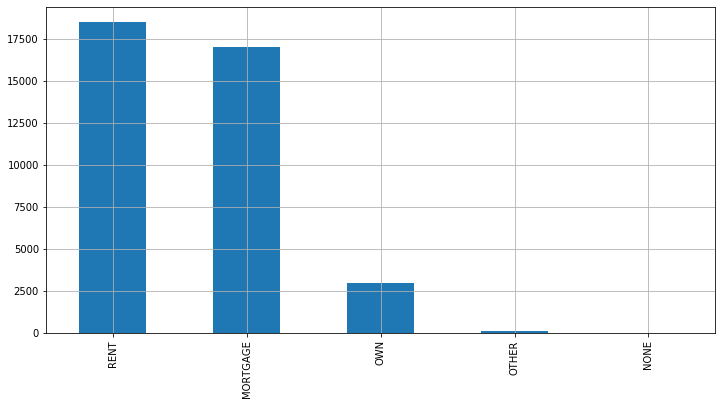

In [105]:
loan_data.home_ownership.value_counts().plot(kind='bar', figsize=ASP_RATIO);
plt.grid()

<h2> <u>Employee Title variable analysis</u> </h2>

In [106]:
emp_title_ = pd.DataFrame(loan_data.emp_title.value_counts())
emp_title_['rank']= emp_title_.rank(method='first', ascending=False)
emp_title_.rename(columns={'emp_title':'counts'}, inplace=True)
emp_title_.head(10)

counts  rank
US Army               131   1.0
Bank of America       107   2.0
IBM                    65   3.0
AT&T                   57   4.0
Kaiser Permanente      56   5.0
USAF                   52   6.0
UPS                    52   7.0
Wells Fargo            52   8.0
US Air Force           51   9.0
Walmart                45  10.0

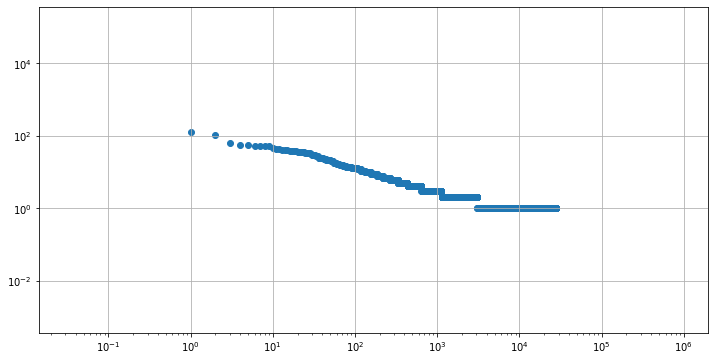

In [107]:
## Rank and frequency distribution plot
fig = plt.figure(figsize=ASP_RATIO)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.scatter(emp_title_['rank'],emp_title_['counts']);

<h2> <u>Annual Income variable analysis</u> </h2>

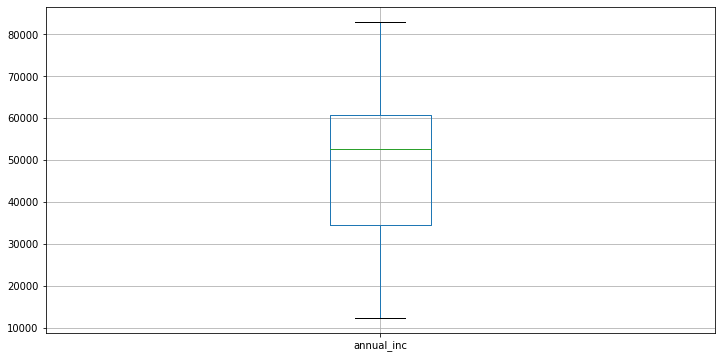

In [108]:
## boxplot to analyze the distribution of annual_income variable 
annual_inc_filter1 = (loan_data['annual_inc'] >=39000) & (loan_data['annual_inc'] <=83000)

loan_data.loc[annual_inc_filter1, 'annual_inc']\
.describe()\
.plot.box(figsize=ASP_RATIO)

plt.grid()

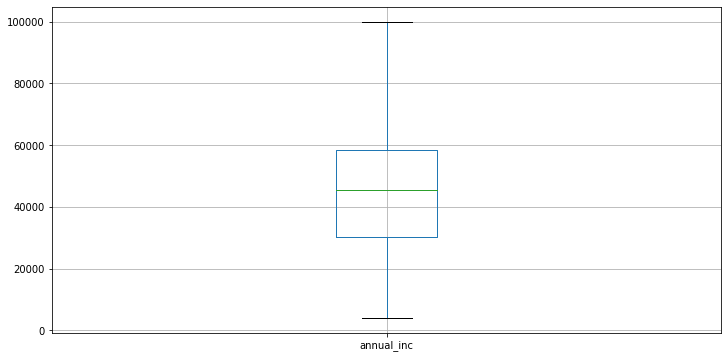

In [109]:
annual_inc_filter2 = (loan_data['annual_inc'] <=10**5)

loan_data.loc[annual_inc_filter2, 'annual_inc']\
.describe()\
.plot.box(figsize=ASP_RATIO)

plt.grid()

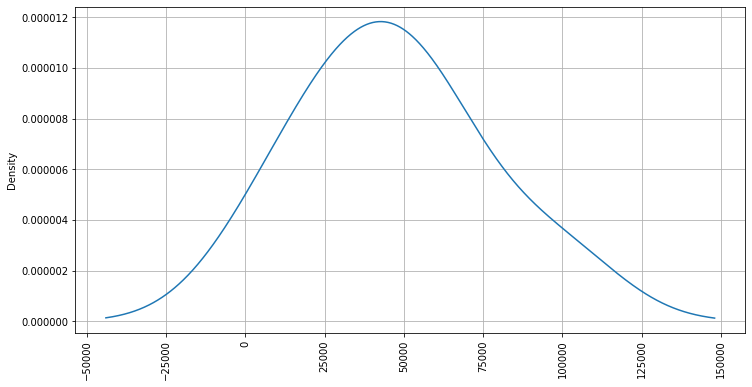

In [110]:
loan_data.loc[annual_inc_filter2,'annual_inc']\
.describe()\
.plot.density(rot=90, figsize=ASP_RATIO);

plt.grid()

In [111]:
loan_data.loc[annual_inc_filter2, 'annual_inc'].describe()

count     33096.000000
mean      54718.949504
std       21255.672109
min        4000.000000
25%       38400.000000
50%       52800.000000
75%       70000.000000
max      100000.000000
Name: annual_inc, dtype: float64

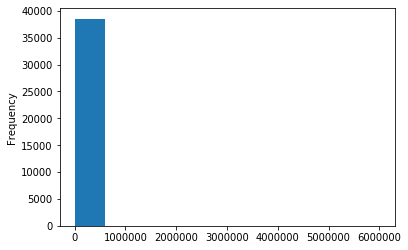

In [112]:
loan_data.annual_inc.plot.hist()

<h2> <u>Delinquency for the last 2 years variable analysis</u> </h2>

In [113]:
loan_data.delinq_2yrs.value_counts()

0     34386
1      3207
2       673
3       212
4        60
5        21
6        10
7         4
8         2
11        1
9         1
Name: delinq_2yrs, dtype: int64

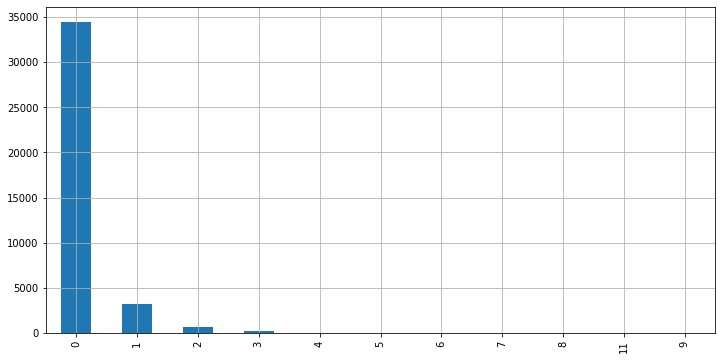

In [114]:
loan_data.loc[:,'delinq_2yrs'].\
value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Employee Job Experience variable analysis</u> </h2>

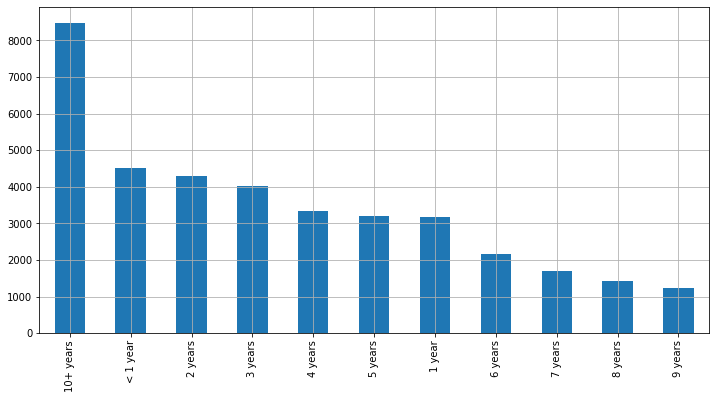

In [115]:
loan_data['emp_length'].value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Funded Amount variable analysis</u> </h2>

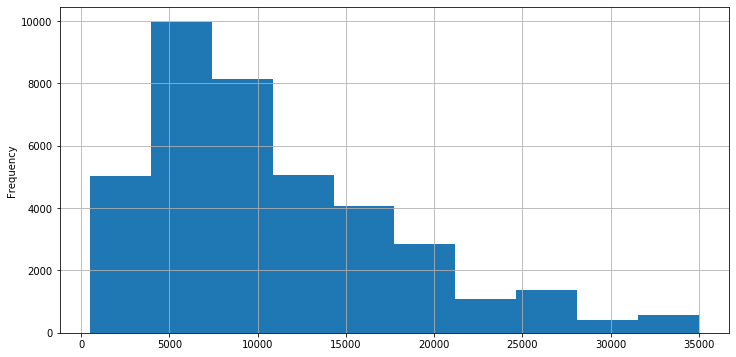

In [116]:
loan_data.funded_amnt.plot.hist(figsize=ASP_RATIO);
plt.grid()

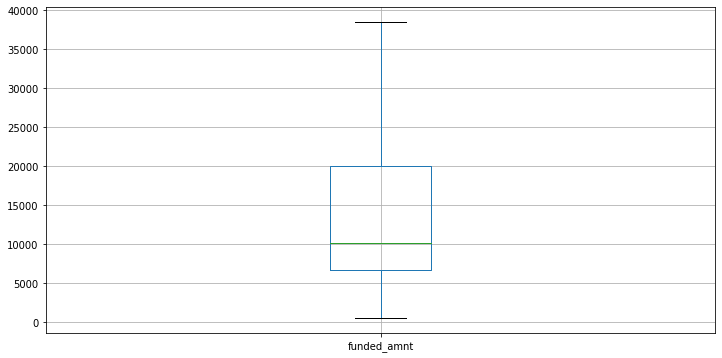

In [117]:
loan_data.funded_amnt.describe().plot.box(figsize=ASP_RATIO)
plt.grid()


<h2> <u>State Address variable analysis</u> </h2>

In [118]:
loan_data.addr_state.shape

(38577,)

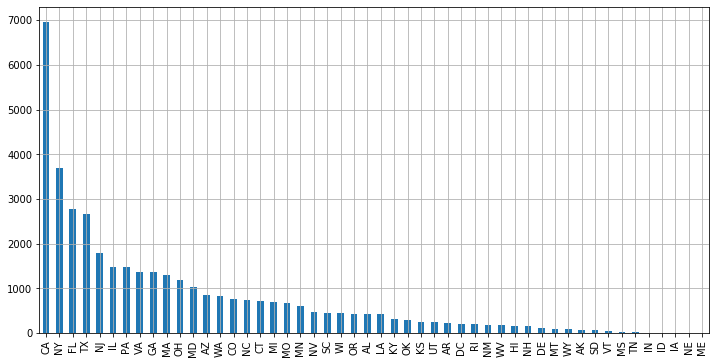

In [119]:
loan_data.addr_state.value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Interest Rate variable analysis</u> </h2>

In [120]:
loan_data.int_rate_derv.shape

(38577,)

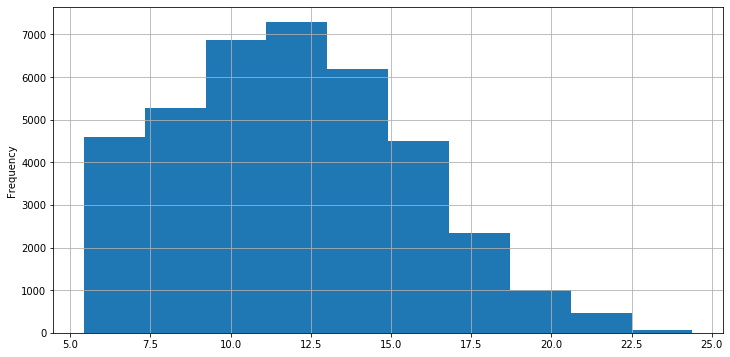

In [121]:
loan_data.int_rate_derv.plot.hist(figsize=ASP_RATIO);
plt.grid()

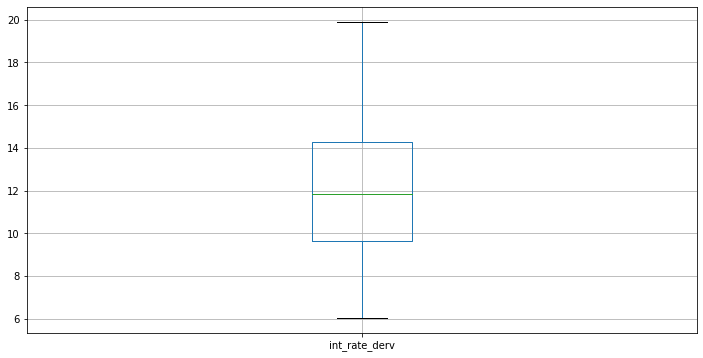

In [122]:
loan_data.loc[(loan_data.int_rate_derv > 6)  & (loan_data.int_rate_derv <= 20), 'int_rate_derv']\
.plot.box(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Interest Amount variable analysis</u> </h2>

In [123]:
loan_data.int_rate_amt_derv.describe()

count     38577.000000
mean     139987.282779
std      121697.735020
min        4035.000000
25%       55160.000000
50%      100620.000000
75%      186900.000000
max      836850.000000
Name: int_rate_amt_derv, dtype: float64

In [124]:
int_rate_amt_int1 = (loan_data.int_rate_amt_derv <= 20000)
int_rate_amt_int2 = (loan_data.int_rate_amt_derv > 20000) & (loan_data.int_rate_amt_derv <= 50000)
int_rate_amt_int3 = (loan_data.int_rate_amt_derv > 50000) & (loan_data.int_rate_amt_derv <= 80000)
int_rate_amt_int4 = (loan_data.int_rate_amt_derv > 80000) & (loan_data.int_rate_amt_derv <= 100000)
int_rate_amt_int5 = (loan_data.int_rate_amt_derv > 100000)

loan_data.loc[int_rate_amt_int1,'int_rate_amt_derv_encode'] = 1
loan_data.loc[int_rate_amt_int2,'int_rate_amt_derv_encode'] = 2 
loan_data.loc[int_rate_amt_int3,'int_rate_amt_derv_encode'] = 3 
loan_data.loc[int_rate_amt_int4,'int_rate_amt_derv_encode'] = 4
loan_data.loc[int_rate_amt_int5,'int_rate_amt_derv_encode'] = 5 

In [125]:
loan_data.int_rate_amt_derv_encode.unique()

array([3., 2., 5., 4., 1.])

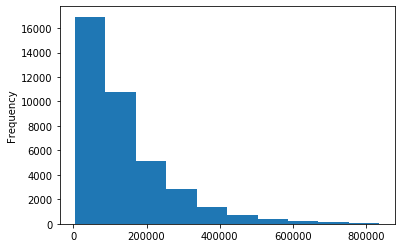

In [126]:
loan_data.int_rate_amt_derv.plot.hist()

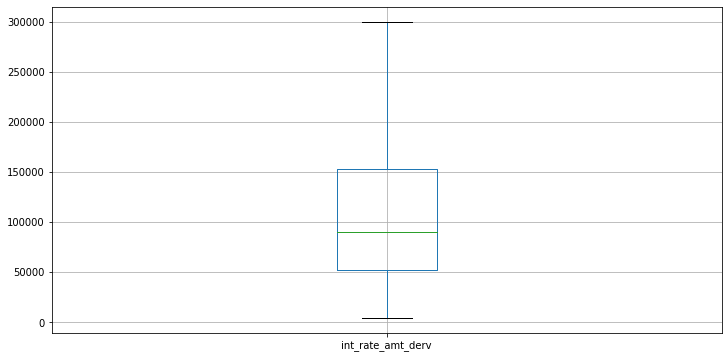

In [127]:
loan_data.loc[loan_data.int_rate_amt_derv <= 3*(10**5),'int_rate_amt_derv'].plot.box(figsize=ASP_RATIO);
plt.grid()

<h2> <u>Target variable analysis</u> </h2>

In [128]:
loan_data.is_defaulter_derv.shape

(38577,)

In [129]:
non_defaulter_percnt = round(loan_data.is_defaulter_derv\
      .value_counts()[0]/loan_data\
      .is_defaulter_derv\
      .value_counts()\
      .sum()*100,2)

defaulter_percnt = round(loan_data.is_defaulter_derv\
      .value_counts()[1]/loan_data\
      .is_defaulter_derv\
      .value_counts()\
      .sum()*100,2)

print(f"DEFAULTER PERCENT --> {str(defaulter_percnt)+'%'}\nNON_DEFAULTER PERCENT --> {str(non_defaulter_percnt)+ '%'}")

DEFAULTER PERCENT --> 14.59%
NON_DEFAULTER PERCENT --> 85.41%


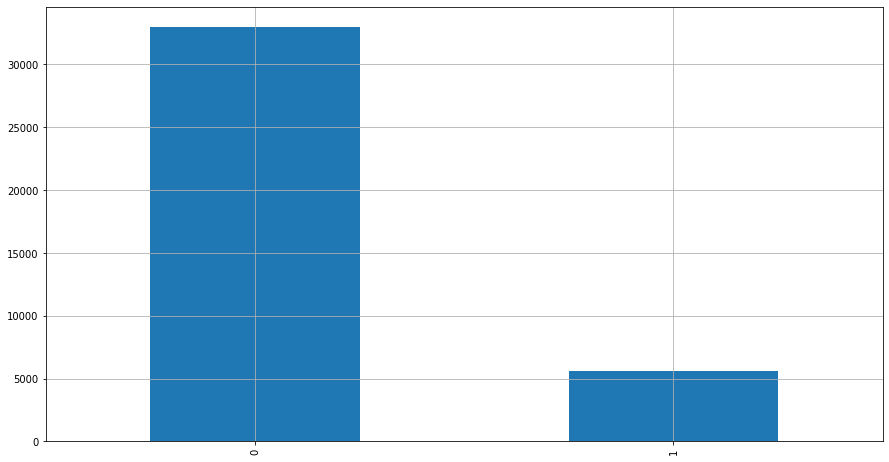

In [130]:
loan_data.is_defaulter_derv.value_counts().plot.bar(figsize=(15,8));
plt.grid()

<h2> <u>Purpose variable analysis</u> </h2>

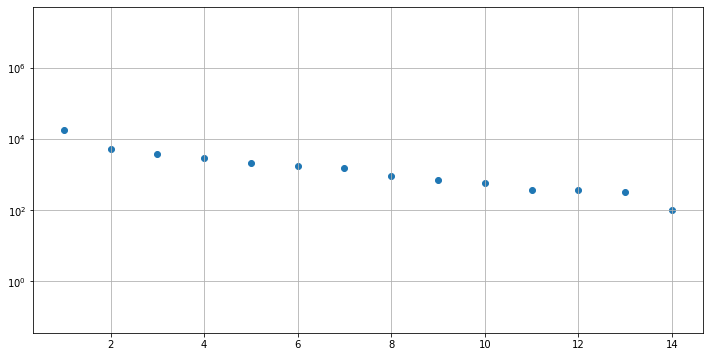

In [131]:
purpose_ = pd.DataFrame(loan_data.purpose.value_counts())
purpose_['rank']= purpose_.rank(method='first', ascending=False)
purpose_.rename(columns={'purpose':'counts'}, inplace=True)
purpose_.head(10)

fig = plt.figure(figsize=ASP_RATIO)
plt.grid()
plt.xscale('linear')
plt.yscale('log')
plt.scatter(purpose_['rank'],purpose_['counts']);

In [132]:
loan_data.purpose.shape

(38577,)

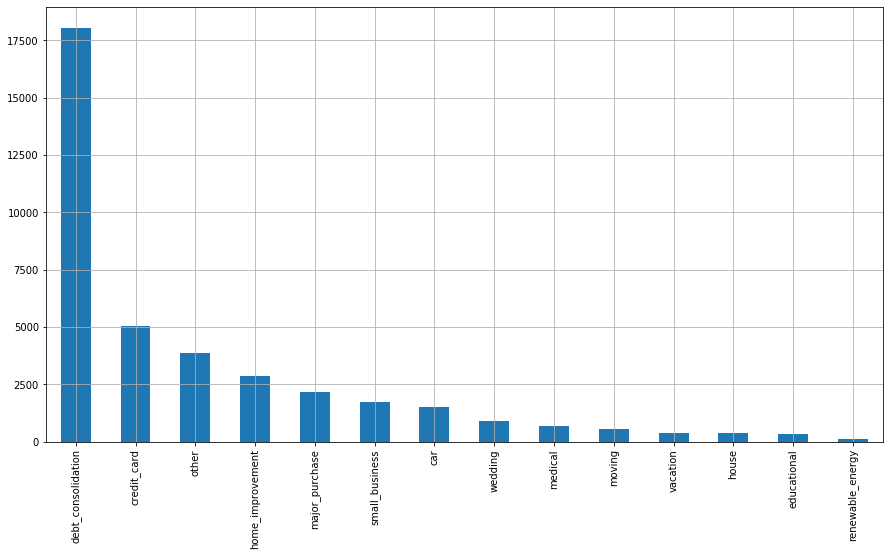

In [133]:
loan_data.purpose.value_counts().plot.bar(figsize=(15,8));
plt.grid()

<h2> <u>Title variable analysis</u> </h2>

In [134]:
loan_data.title.shape

(38577,)

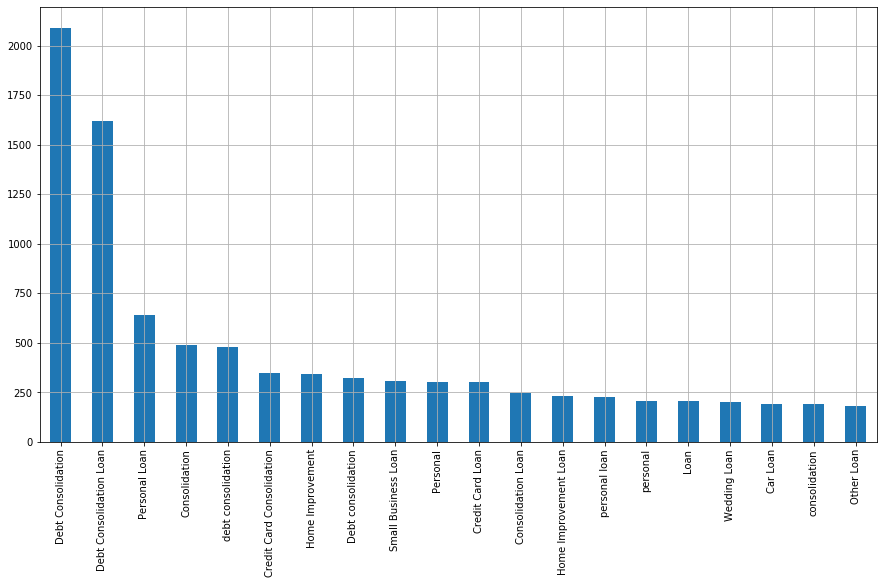

In [135]:
loan_data.title.value_counts()[:20].plot.bar(figsize=(15,8))
plt.grid()

<h2> <u>Grade variable analysis</u> </h2>

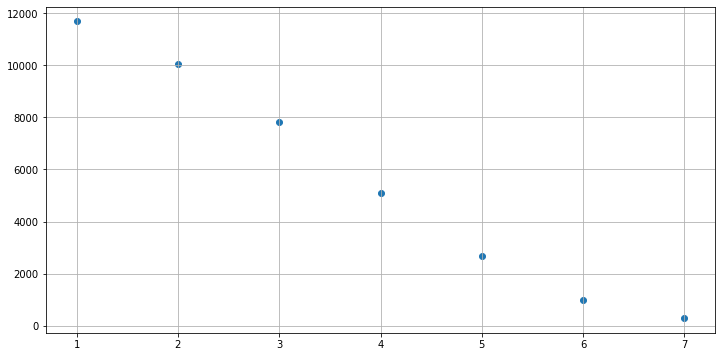

In [136]:
grade_ = pd.DataFrame(loan_data.grade.value_counts())
grade_['rank']= grade_.rank(method='first', ascending=False)
grade_.rename(columns={'grade':'counts'}, inplace=True)
grade_.head(10)

fig = plt.figure(figsize=ASP_RATIO)
plt.grid()
plt.xscale('linear')
plt.yscale('linear')
plt.scatter(grade_['rank'],grade_['counts']);

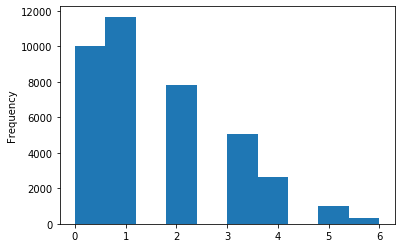

In [137]:
loan_data['grade_encoded_derv'].plot.hist()

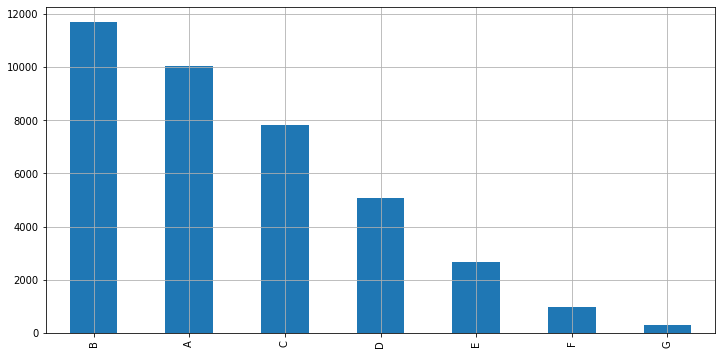

In [138]:
loan_data.grade.value_counts().plot.bar(figsize=ASP_RATIO);
plt.grid();

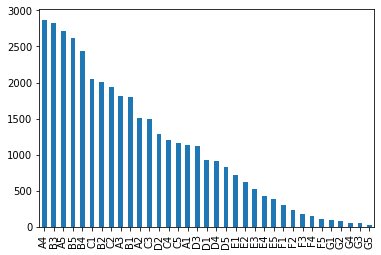

In [139]:
loan_data.sub_grade.value_counts().plot.bar()

In [140]:
round((loan_data.groupby('grade')['funded_amnt_inv'].sum()/loan_data['funded_amnt_inv'].sum())*100,2)

grade
A    20.75
B    30.03
C    19.57
D    14.47
E     9.64
F     4.11
G     1.43
Name: funded_amnt_inv, dtype: float64

In [141]:
fainv1 = (loan_data.funded_amnt_inv <= 5000)
fainv2 = (loan_data.funded_amnt_inv > 5000)& (loan_data.funded_amnt_inv <= 10000)
fainv3 = (loan_data.funded_amnt_inv > 10000)& (loan_data.funded_amnt_inv <= 15000)
fainv4 = (loan_data.funded_amnt_inv > 15000)

loan_data.loc[fainv1,'funded_amnt_inv_encode_derv'] = 1
loan_data.loc[fainv2,'funded_amnt_inv_encode_derv'] = 2
loan_data.loc[fainv3,'funded_amnt_inv_encode_derv'] = 3
loan_data.loc[fainv4,'funded_amnt_inv_encode_derv'] = 4

In [142]:
loan_data.funded_amnt_inv_encode_derv.unique()

array([1., 2., 3., 4.])

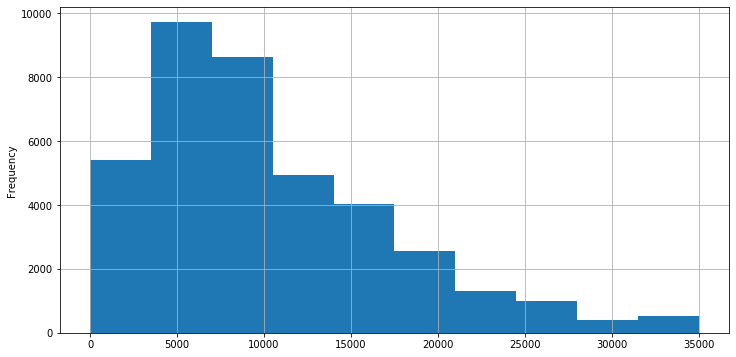

In [143]:
loan_data.funded_amnt_inv.plot.hist(figsize=ASP_RATIO);
plt.grid()

In [144]:
def encode_pub_rec(val):
    if val == 1 or val==0:
        return val
    else:
        return 1
    

In [145]:
loan_data['pub_rec_derv']= loan_data.pub_rec.apply(encode_pub_rec)

In [146]:
loan_data.pub_rec.value_counts()

0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64

<h1> <center><u>Bivariate Analysis</u></center></h1>

<h4> <u>No of Months passed since last time, when the payment of loan was missed vs Target variable analysis</u> </h4>

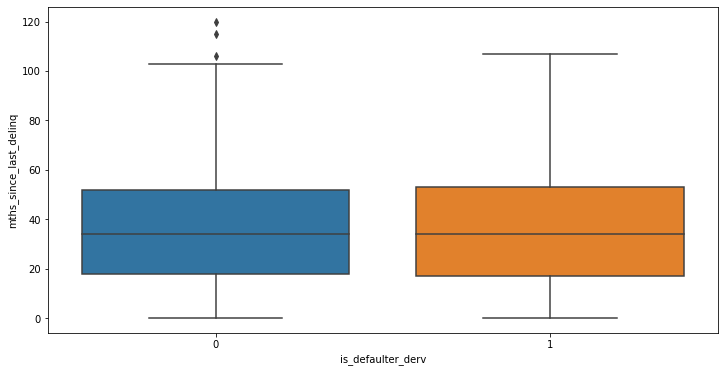

In [147]:
fig_dims = ASP_RATIO
fig_msld, ax_msld = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='mths_since_last_delinq', data=loan_data, ax=ax_msld);

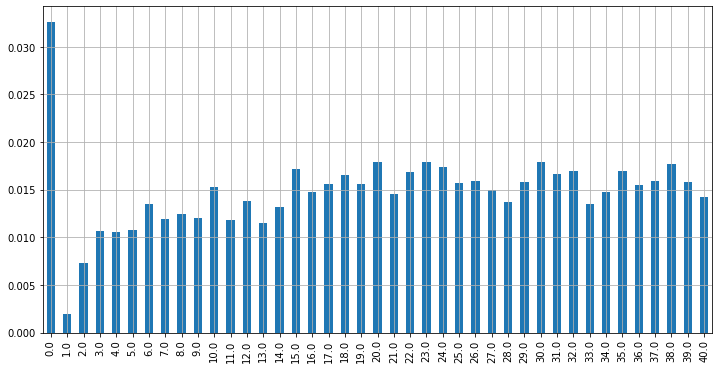

In [148]:
(loan_data[(loan_data.is_defaulter_derv==0)]['mths_since_last_delinq'].value_counts()/\
loan_data[(loan_data.is_defaulter_derv==0)]['mths_since_last_delinq'].value_counts().sum()).sort_index()\
[:40].plot(kind='bar', figsize=ASP_RATIO)
plt.grid()

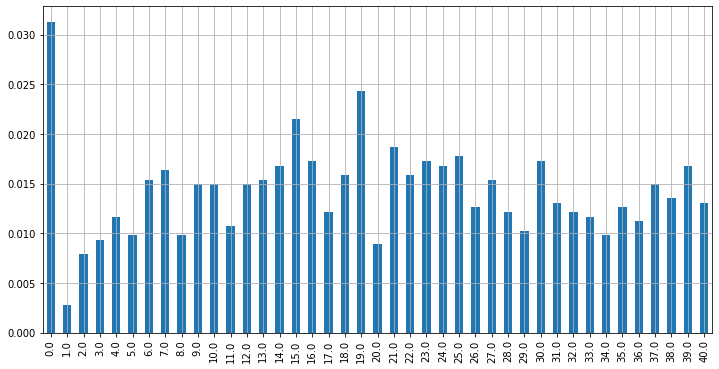

In [149]:
(loan_data[(loan_data.is_defaulter_derv==1)]['mths_since_last_delinq'].value_counts()/\
loan_data[(loan_data.is_defaulter_derv==1)]['mths_since_last_delinq'].value_counts().sum()).sort_index()\
[:40].plot(kind='bar', figsize=ASP_RATIO)
plt.grid()

In [153]:

msld1 = (loan_data.mths_since_last_delinq <= 20)
msld2 = (loan_data.mths_since_last_delinq > 20)& (loan_data.mths_since_last_delinq <= 50)
msld3 = (loan_data.mths_since_last_delinq > 50)


loan_data.loc[msld1,'mths_since_last_delinq_derv'] = 1 
loan_data.loc[msld2,'mths_since_last_delinq_derv'] = 2 
loan_data.loc[msld3,'mths_since_last_delinq_derv'] = 3


woe_df_msld = pd.DataFrame()

min_val =[
    loan_data.loc[msld1,'mths_since_last_delinq'].min(),
loan_data.loc[msld2,'mths_since_last_delinq'].min(),
loan_data.loc[msld3,'mths_since_last_delinq'].min()]

max_val =[
    loan_data.loc[msld1,'mths_since_last_delinq'].max(),
    loan_data.loc[msld2,'mths_since_last_delinq'].max(),
    loan_data.loc[msld3,'mths_since_last_delinq'].max()
]

count_events = [
loan_data.loc[msld1 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[msld2 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[msld3 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count()]

count_non_events =[
loan_data.loc[msld1 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[msld2 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[msld3 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count()
]

loan_data.mths_since_last_delinq_derv.value_counts().sort_index()

count = loan_data.mths_since_last_delinq_derv.value_counts().sort_index().values.tolist()
loan_data.mths_since_last_delinq_derv.value_counts().sort_index().values.tolist()

woe_df_msld['variable_name'] = "mths_since_last_delinq"
woe_df_msld['min_val_'] = min_val
woe_df_msld['max_val_'] = max_val
woe_df_msld['count_'] = count
woe_df_msld['count_events_'] = count_events
woe_df_msld['count_non_events_'] = count_non_events
woe_df_msld['%_count_events'] = round((woe_df_msld.count_events_/woe_df_msld.count_events_.sum()),4)\
.values*100

woe_df_msld['%_non_count_events']= round((woe_df_msld.count_non_events_/woe_df_msld.count_non_events_.sum()),4)\
.values*100

woe_df_msld['WOE'] = (woe_df_msld['%_count_events']/woe_df_msld['%_non_count_events']).apply(math.log)
woe_df_msld['diff_event_%_non_event'] = (woe_df_msld['%_count_events'] - woe_df_msld['%_non_count_events'])
woe_df_msld['IV'] = round((woe_df_msld['diff_event_%_non_event']*woe_df_msld['WOE']),2)

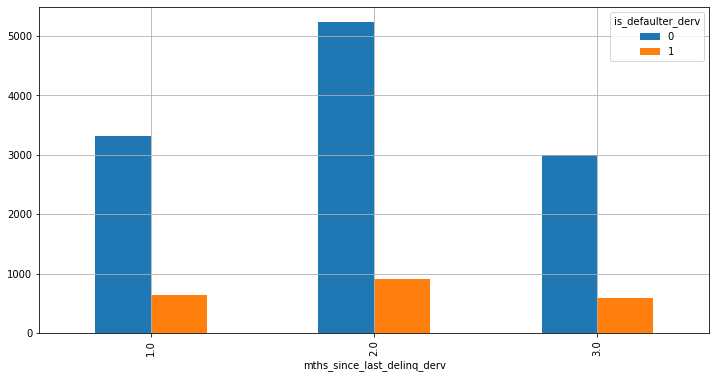

In [154]:
pd.crosstab(loan_data.mths_since_last_delinq_derv,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO);
plt.savefig('bar_plot_ann_sal_vs_deflt_state.png')
plt.grid()

In [155]:
woe_df_msld['variable_name'] = "mths_since_last_delinq"

In [156]:
woe_df_msld

variable_name  min_val_  max_val_  count_  count_events_  \
0  mths_since_last_delinq       0.0      20.0    3955            647   
1  mths_since_last_delinq      21.0      50.0    6132            907   
2  mths_since_last_delinq      51.0     120.0    3585            588   

   count_non_events_  %_count_events  %_non_count_events       WOE  \
0               3308           30.21               28.69  0.051624   
1               5225           42.34               45.32 -0.068016   
2               2997           27.45               25.99  0.054654   

   diff_event_%_non_event    IV  
0                    1.52  0.08  
1                   -2.98  0.20  
2                    1.46  0.08

In [157]:
round(woe_df_msld.IV.sum(),2)

0.36

<h4> <u>Public Rec is a number number of derogatory records, which lender considers risk. Comparision of it vs Target variable analysis</u> </h4>


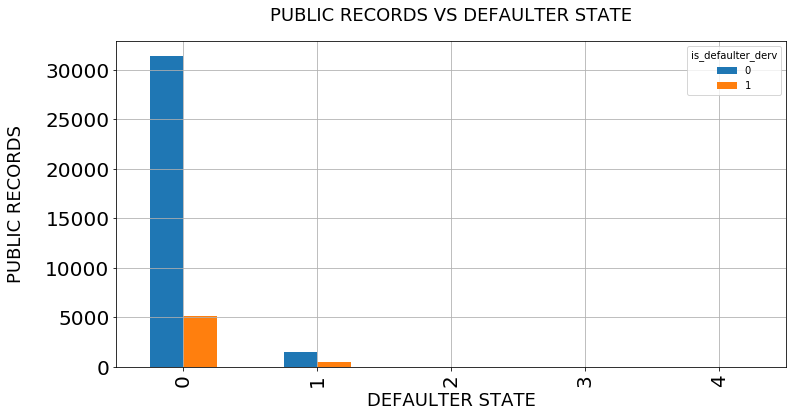

In [158]:
fig_ann_inc, ax_pub_rec = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.pub_rec,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_pub_rec);
ax_pub_rec.set_title("PUBLIC RECORDS VS DEFAULTER STATE", pad=20, fontsize=18)
ax_pub_rec.set_xlabel('DEFAULTER STATE', fontsize=18, labelpad=5);
ax_pub_rec.set_ylabel('PUBLIC RECORDS', fontsize=18, labelpad=20);
ax_pub_rec.tick_params(axis='both', which='major', labelsize=20);
# ax_pub_rec.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0);
plt.grid()
plt.savefig('bar_plot_pub_rec_vs_deflt_state.png')

In [159]:
loan_data.pub_rec.value_counts()

0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64

In [160]:
defaulter_prcnt_pub_rec = round((loan_data[loan_data.is_defaulter_derv==1]['pub_rec'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==1]['pub_rec'].value_counts().sum())*100,2)

non_defaulter_pub_rec = round((loan_data[loan_data.is_defaulter_derv==0]['pub_rec'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==0]['pub_rec'].value_counts().sum())*100,2)

pub_rec_dfltr_vs_non_dfltr = pd.concat([defaulter_prcnt_pub_rec, non_defaulter_pub_rec], axis='columns')

pub_rec_dfltr_vs_non_dfltr.columns = ['Defaulter_prcnt', 'Non_Defaulter_prcnt']

pub_rec_dfltr_vs_non_dfltr['Diff_Defaulter_prcnt_Non_Defaulter_prcnt'] = \
(pub_rec_dfltr_vs_non_dfltr['Defaulter_prcnt']-pub_rec_dfltr_vs_non_dfltr['Non_Defaulter_prcnt'])

pub_rec_dfltr_vs_non_dfltr

Defaulter_prcnt  Non_Defaulter_prcnt  \
0            91.70                95.14   
1             8.12                 4.72   
2             0.18                 0.12   
3              NaN                 0.02   
4              NaN                 0.01   

   Diff_Defaulter_prcnt_Non_Defaulter_prcnt  
0                                     -3.44  
1                                      3.40  
2                                      0.06  
3                                       NaN  
4                                       NaN

In [161]:
perfrom_chi_2_test(loan_data,'pub_rec','is_defaulter_derv')

 P_value for chi_2 test between pub_rec and is_defaulter_derv 0.0


<h4> <u>Annual Income vs Target variable analysis</u> </h4>

In [162]:
MUL_1K = 10**3

l1 =    (loan_data.annual_inc <= 40*MUL_1K)
l2 =    (loan_data.annual_inc > 40*MUL_1K)& (loan_data.annual_inc <= 50*MUL_1K)
l3 =    (loan_data.annual_inc > 50*MUL_1K)& (loan_data.annual_inc <= 80*MUL_1K)
l4 =    (loan_data.annual_inc > 80*MUL_1K) 


loan_data.loc[l1,'annual_inc_derv'] = 1 
loan_data.loc[l2,'annual_inc_derv'] = 2 
loan_data.loc[l3,'annual_inc_derv'] = 3
loan_data.loc[l4,'annual_inc_derv'] = 4


woe_df = pd.DataFrame()

min_val =[
    loan_data.loc[l1,'annual_inc'].min(),
loan_data.loc[l2,'annual_inc'].min(),
loan_data.loc[l3,'annual_inc'].min(),
    loan_data.loc[l4,'annual_inc'].min()
]

max_val =[
    loan_data.loc[l1,'annual_inc'].max(),
    loan_data.loc[l2,'annual_inc'].max(),
    loan_data.loc[l3,'annual_inc'].max(),
    loan_data.loc[l4,'annual_inc'].max()
]

count_events = [
loan_data.loc[l1 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[l2 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
loan_data.loc[l3 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count(),
    loan_data.loc[l4 & (loan_data.is_defaulter_derv==1),'is_defaulter_derv'].count()
]

count_non_events =[
loan_data.loc[l1 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[l2 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
loan_data.loc[l3 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count(),
    loan_data.loc[l4 & (loan_data.is_defaulter_derv==0),'is_defaulter_derv'].count()
]

loan_data.annual_inc_derv.value_counts().sort_index()

count = loan_data.annual_inc_derv.value_counts().sort_index().values.tolist()
loan_data.annual_inc_derv.value_counts().sort_index().values.tolist()

woe_df['variable_name'] = 'annual_income'
woe_df['min_val_'] = min_val
woe_df['max_val_'] = max_val
woe_df['count_'] = count
woe_df['count_events_'] = count_events
woe_df['count_non_events_'] = count_non_events
woe_df['%_count_events'] = round((woe_df.count_events_/woe_df.count_events_.sum()),4).values*100
woe_df['%_non_count_events']= round((woe_df.count_non_events_/woe_df.count_non_events_.sum()),4).values*100
woe_df['WOE'] = (woe_df['%_count_events']/woe_df['%_non_count_events']).apply(math.log)
woe_df['diff_event_%_non_event'] = (woe_df['%_count_events'] - woe_df['%_non_count_events'])
woe_df['IV'] = round((woe_df['diff_event_%_non_event']*woe_df['WOE']),2)

In [163]:
woe_df['variable_name'] = 'annual_income'

In [164]:
woe_df

variable_name  min_val_   max_val_  count_  count_events_  \
0  annual_income   4000.00    40000.0    9698           1751   
1  annual_income  40008.00    50000.0    5691            862   
2  annual_income  50000.04    80000.0   13193           1891   
3  annual_income  80004.00  6000000.0    9995           1123   

   count_non_events_  %_count_events  %_non_count_events       WOE  \
0               7947           31.12               24.12  0.254809   
1               4829           15.32               14.66  0.044036   
2              11302           33.61               34.30 -0.020322   
3               8872           19.96               26.93 -0.299511   

   diff_event_%_non_event    IV  
0                    7.00  1.78  
1                    0.66  0.03  
2                   -0.69  0.01  
3                   -6.97  2.09

In [165]:
woe_df.IV.sum()

3.91

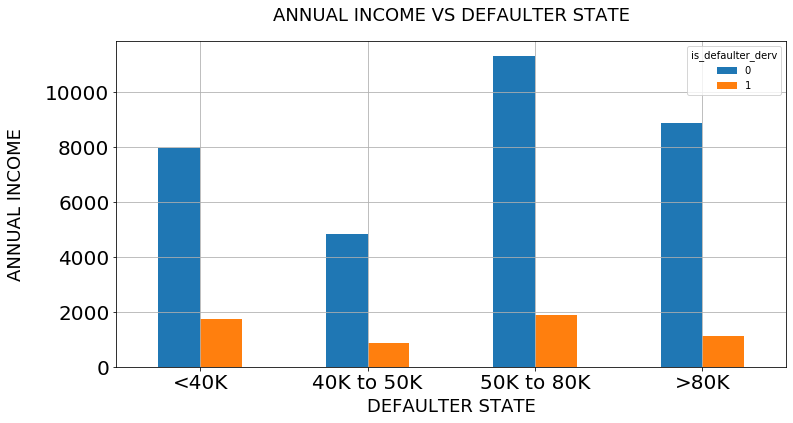

In [166]:
fig_ann_inc, ax_ann_inc = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.annual_inc_derv,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_ann_inc);

ax_ann_inc.set_title("ANNUAL INCOME VS DEFAULTER STATE", pad=20, fontsize=18)
ax_ann_inc.set_xlabel('DEFAULTER STATE', fontsize=18, labelpad=5);
ax_ann_inc.set_ylabel('ANNUAL INCOME', fontsize=18, labelpad=20);
ax_ann_inc.tick_params(axis='both', which='major', labelsize=20);
ax_ann_inc.set_xticklabels(['<40K', '40K to 50K','50K to 80K','>80K'], rotation=0);
plt.grid()
plt.savefig('bar_plot_ann_sal_vs_deflt_state.png')


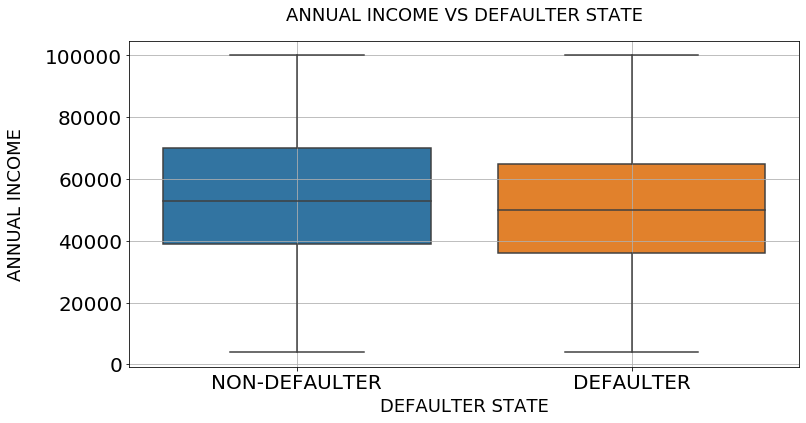

In [167]:
fig_dims = ASP_RATIO
fig, ax_ann_inc_box = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='annual_inc', data=loan_data[loan_data.annual_inc < (1*(10**5))],\
            ax=ax_ann_inc_box);

ax_ann_inc_box.set_title("ANNUAL INCOME VS DEFAULTER STATE", pad=20, fontsize=18)
ax_ann_inc_box.set_xlabel('DEFAULTER STATE', fontsize=18, labelpad=5);
ax_ann_inc_box.set_ylabel('ANNUAL INCOME', fontsize=18, labelpad=20);
ax_ann_inc_box.tick_params(axis='both', which='major', labelsize=20);
ax_ann_inc_box.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0);
plt.grid()
plt.savefig('box_plot_ann_sal_vs_deflt_state.png')


In [168]:
perfrom_chi_2_test(loan_data,'is_defaulter_derv','annual_inc_derv')

 P_value for chi_2 test between is_defaulter_derv and annual_inc_derv 0.0


<h4> <u>Interest Amount vs Target variable analysis</u> </h4>

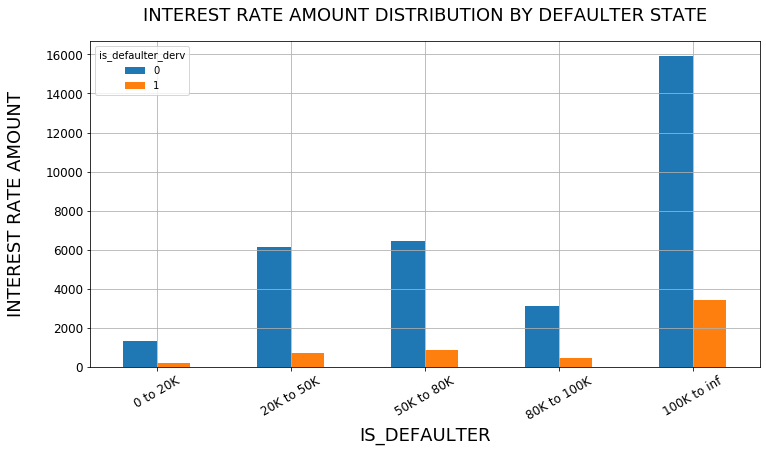

In [169]:
fig_int_rate_amnt_bar, ax_int_rate_amnt_bar = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.int_rate_amt_derv_encode,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_int_rate_amnt_bar);

ax_int_rate_amnt_bar.set_title("INTEREST RATE AMOUNT DISTRIBUTION BY DEFAULTER STATE", pad=20, fontsize=18)
ax_int_rate_amnt_bar.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_int_rate_amnt_bar.set_ylabel('INTEREST RATE AMOUNT', fontsize=18, labelpad=20);
ax_int_rate_amnt_bar.tick_params(axis='both', which='major', labelsize=12);
ax_int_rate_amnt_bar.set_xticklabels(['0 to 20K','20K to 50K','50K to 80K','80K to 100K','100K to inf']\
                                    , rotation=30);
plt.grid()
plt.savefig('bar_int_rate_vs_defaulter.png')

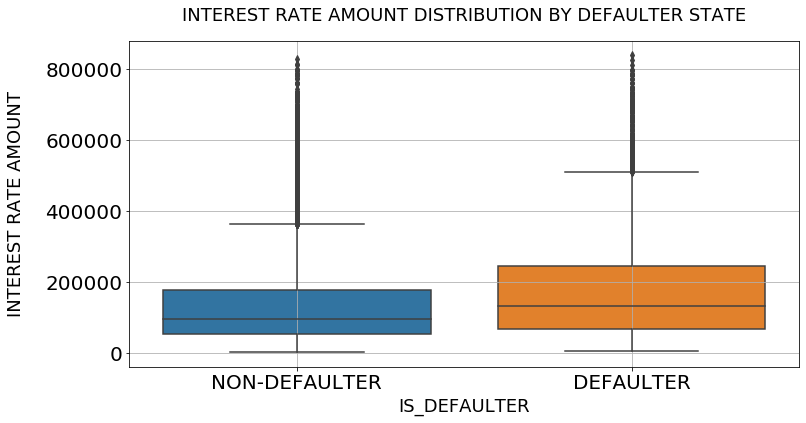

In [170]:
fig_int_rate_amnt_bar, ax_int_rate_amnt_box = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='int_rate_amt_derv', data=loan_data, ax=ax_int_rate_amnt_box);
ax_int_rate_amnt_box.set_title("INTEREST RATE AMOUNT DISTRIBUTION BY DEFAULTER STATE", pad=20, fontsize=18)
ax_int_rate_amnt_box.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_int_rate_amnt_box.set_ylabel('INTEREST RATE AMOUNT', fontsize=18, labelpad=20);
ax_int_rate_amnt_box.tick_params(axis='both', which='major', labelsize=20);
ax_int_rate_amnt_box.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0)
plt.grid()
plt.savefig('box_int_rate_amnt.png')

In [171]:
perfrom_chi_2_test(loan_data,'int_rate_amt_derv_encode','is_defaulter_derv')

 P_value for chi_2 test between int_rate_amt_derv_encode and is_defaulter_derv 0.0


<h4> <u>The actual investment amount issued vs Target variable analysis</u> </h4>

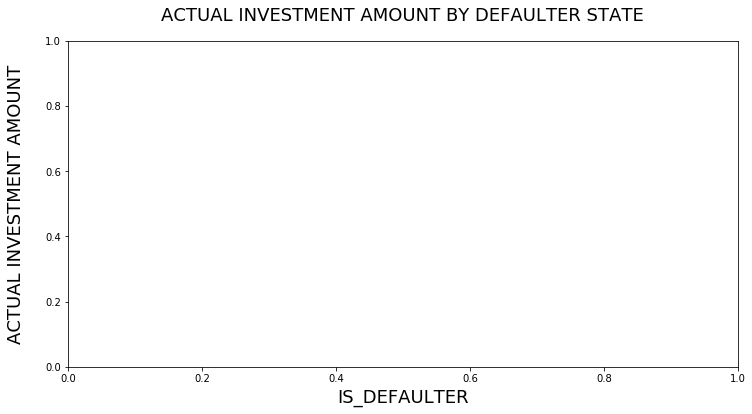

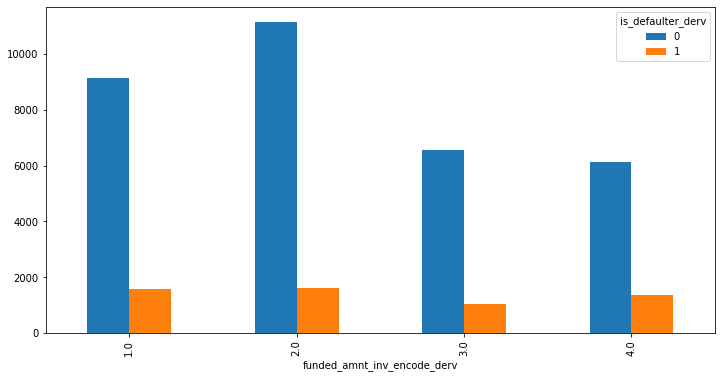

In [172]:
fig_funded_amnt_inv, ax_funded_amnt_inv = plt.subplots(figsize=ASP_RATIO) 
pd.crosstab(loan_data.funded_amnt_inv_encode_derv,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO);
ax_funded_amnt_inv.set_title("ACTUAL INVESTMENT AMOUNT BY DEFAULTER STATE", pad=20, fontsize=18)
ax_funded_amnt_inv.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_funded_amnt_inv.set_ylabel('ACTUAL INVESTMENT AMOUNT', fontsize=18, labelpad=20);
# ax_funded_amnt_inv.tick_params(axis='both', which='major', labelsize=20);
# ax_funded_amnt_inv.set_xticklabels(['NON-DEFAULTER','DEFAULTER'], rotation=0)



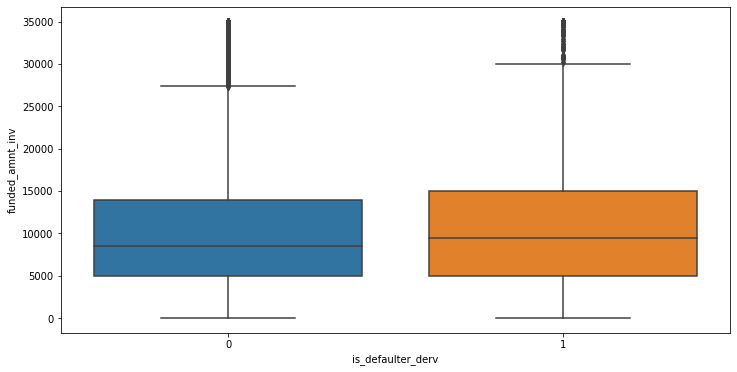

In [173]:
fig2, ax2 = plt.subplots(figsize=fig_dims)
sns.boxplot(x='is_defaulter_derv', y='funded_amnt_inv', data=loan_data, ax=ax2);

In [174]:
perfrom_chi_2_test(loan_data,'funded_amnt_inv_encode_derv','is_defaulter_derv')

 P_value for chi_2 test between funded_amnt_inv_encode_derv and is_defaulter_derv 0.0


<h4> <u>Purpose vs Target variable analysis</u> </h4>

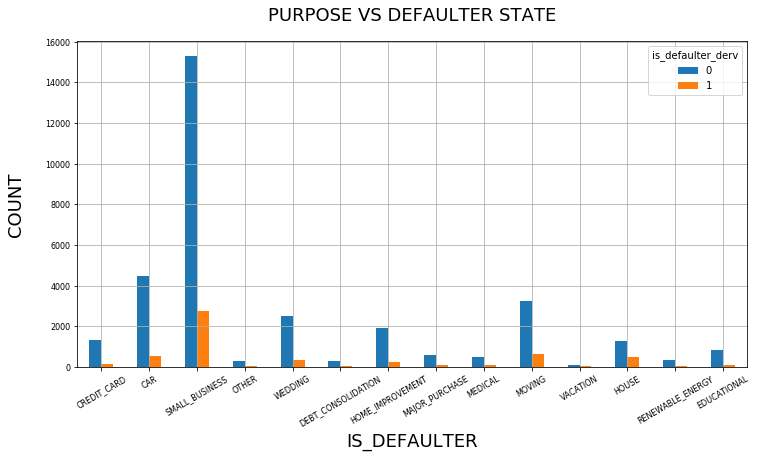

In [175]:
purpose_labels=[label.upper() for label in loan_data.purpose.unique().tolist()]
fig_purpose_bar, ax_purpose_bar = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.purpose,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_purpose_bar);

ax_purpose_bar.set_title("PURPOSE VS DEFAULTER STATE", pad=20, fontsize=18)
ax_purpose_bar.set_xlabel('IS_DEFAULTER', fontsize=18, labelpad=5);
ax_purpose_bar.set_ylabel('COUNT', fontsize=18, labelpad=20);
ax_purpose_bar.tick_params(axis='both', which='major', labelsize=8);
ax_purpose_bar.set_xticklabels(purpose_labels, rotation=30)
plt.savefig('bar_purpose.png')
plt.grid()

Purpose of the loan plays a significant role in determing the chances of getting default or not. As it can be observed that if the loan purpose is debt_consolidation, home_improvement, other, small_business and credit_card then there are chances of getting default is high unlike other loan purpose. 

In [176]:
perfrom_chi_2_test(loan_data,'is_defaulter_derv','purpose')

 P_value for chi_2 test between is_defaulter_derv and purpose 0.0


<h4> <u>Home Ownership vs Target variable analysis</u> </h4>

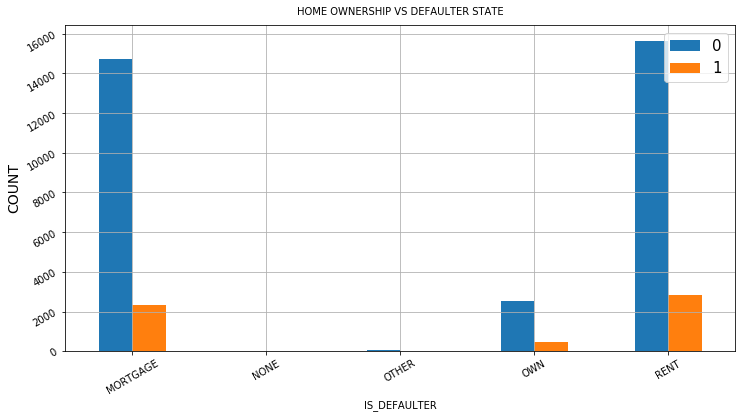

In [178]:
home_own_labels=[label.upper() for label in loan_data.home_ownership.unique().tolist()]
fig_int_rate_amnt_bar, ax_home_ownership = plt.subplots(figsize=fig_dims)
pd.crosstab(loan_data.home_ownership,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO, ax=ax_home_ownership);

ax_home_ownership.set_title("HOME OWNERSHIP VS DEFAULTER STATE", pad=10, fontsize=10)
ax_home_ownership.set_xlabel('IS_DEFAULTER', fontsize=10);
ax_home_ownership.set_ylabel('COUNT', fontsize=14, labelpad=5);
ax_home_ownership.tick_params(axis='both', which='major', labelsize=10, rotation=30);
# ax_home_ownership.set_xticklabels(home_own_labels, rotation=30)

plt.legend(loc=1,prop={'size': 15});
plt.grid()
plt.savefig('home_own_bar.png')

It seems the one who owns has lesser chance of becoming defaulter and greater for those who are on rent and mortgage

In [179]:
perfrom_chi_2_test(loan_data,'home_ownership','is_defaulter_derv')

 P_value for chi_2 test between home_ownership and is_defaulter_derv 0.0


<h4> <u>Grade vs Target variable analysis</u> </h4>

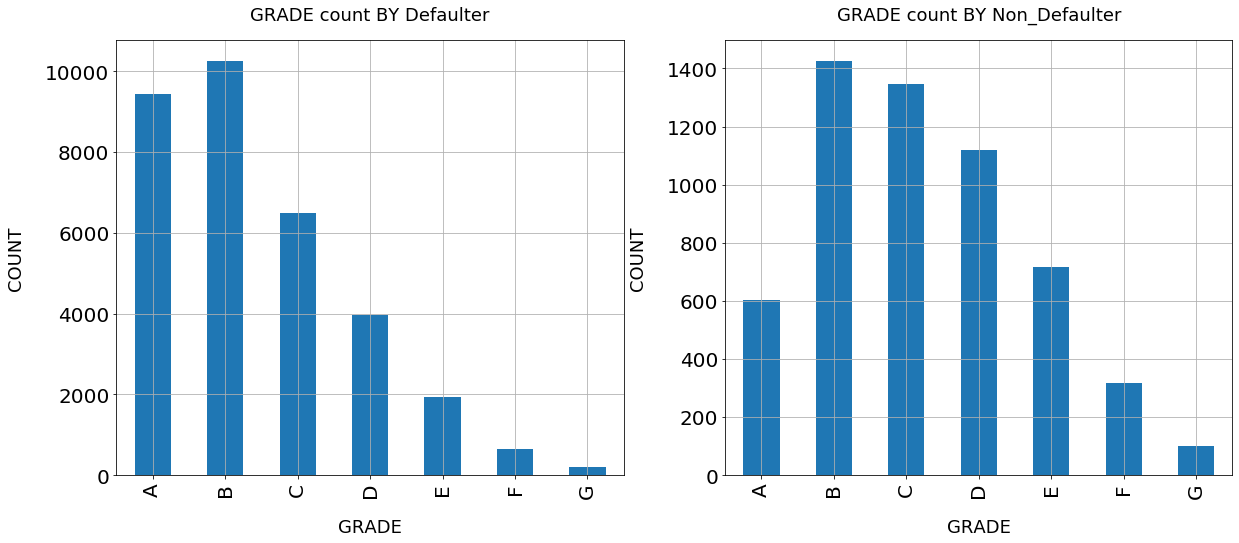

In [180]:
fig_grade, ax_grade = plt.subplots(1,2, figsize=(20,8))

loan_data[loan_data.is_defaulter_derv==0]['grade']\
.value_counts()\
.sort_index()\
.plot(kind='bar', ax=ax_grade[0]);

loan_data[loan_data.is_defaulter_derv==1]['grade']\
.value_counts()\
.sort_index()\
.plot(kind='bar', ax=ax_grade[1]);

ax_grade[0].set_title("GRADE count BY Defaulter", pad=20, fontsize=18)
ax_grade[0].set_xlabel('GRADE', fontsize=18, labelpad=20);
ax_grade[0].set_ylabel('COUNT', fontsize=18, labelpad=20);
ax_grade[0].tick_params(axis='both', which='major', labelsize=20);
ax_grade[0].grid()

ax_grade[1].set_title("GRADE count BY Non_Defaulter", pad=20, fontsize=18)
ax_grade[1].set_xlabel('GRADE', fontsize=18, labelpad=20);
ax_grade[1].set_ylabel('COUNT', fontsize=18, labelpad=20);

ax_grade[1].tick_params(axis='both', which='major', labelsize=20);

ax_grade[1].grid()

In [181]:
defaulter_prcnt = round((loan_data[loan_data.is_defaulter_derv==1]['grade'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==1]['grade'].value_counts().sum())*100,2)

non_defaulter_prcnt = round((loan_data[loan_data.is_defaulter_derv==0]['grade'].value_counts().sort_index()/\
loan_data[loan_data.is_defaulter_derv==0]['grade'].value_counts().sum())*100,2)

grade_dfltr_vs_non_dfltr = pd.concat([defaulter_prcnt, non_defaulter_prcnt], axis='columns')

grade_dfltr_vs_non_dfltr.columns = ['Defaulter_prcnt', 'Non_Defaulter_prcnt']

grade_dfltr_vs_non_dfltr['Diff_Defaulter_prcnt_Non_Defaulter_prcnt'] = \
(grade_dfltr_vs_non_dfltr['Defaulter_prcnt']-grade_dfltr_vs_non_dfltr['Non_Defaulter_prcnt'])

grade_dfltr_vs_non_dfltr

Defaulter_prcnt  Non_Defaulter_prcnt  \
A            10.70                28.66   
B            25.32                31.11   
C            23.94                19.69   
D            19.87                12.04   
E            12.71                 5.91   
F             5.67                 1.99   
G             1.79                 0.60   

   Diff_Defaulter_prcnt_Non_Defaulter_prcnt  
A                                    -17.96  
B                                     -5.79  
C                                      4.25  
D                                      7.83  
E                                      6.80  
F                                      3.68  
G                                      1.19

<h4>Findings : When the target variable moves from Non_Defaulter to Defaulter</h4>
<ol>
    <li>There is a significant negative change of <b>(-17.96)% in GRADE A.</b></li>
    <li>There is a significant negative change of <b>(-5.79)% in GRADE B.</b> </li>
    <li>There is a significant positive change of <b>4.25% in GRADE C.</b></li>
    <li>There is a significant positive change of <b>7.83% in GRADE D.</b></li>
    <li>There is a significant positive change of <b>6.80% in GRADE E.</b></li>
    <li>There is a significant positive change of <b>3.68% in GRADE F.</b></li>
    <li>There is a slight positive change of <b>1.19% in GRADE G.</b></li>
</ol>

<h4> <u>Loan issue month vs Target variable analysis</u> </h4>

In [183]:
loan_data['issue_month_derv']= loan_data.issue_d.apply(lambda val: val.split('-')[0])

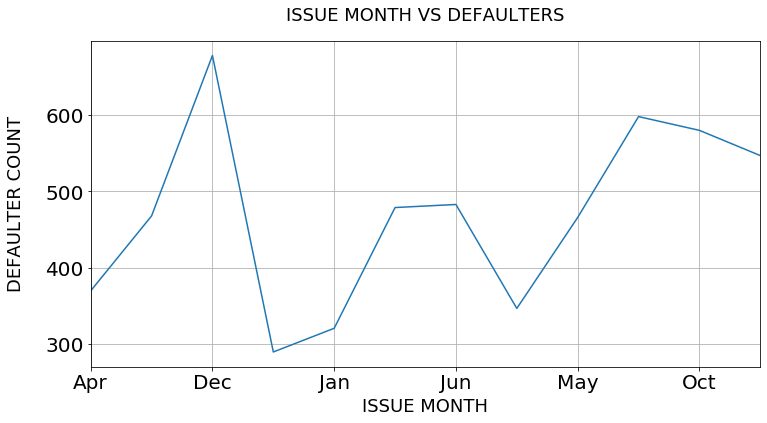

In [185]:
fig_issue_mnth, ax_issue_mnth = plt.subplots()
loan_data[loan_data.is_defaulter_derv==1].groupby('issue_month_derv')['is_defaulter_derv']\
.value_counts()\
.sort_index().unstack().plot(figsize=ASP_RATIO, ax=ax_issue_mnth, legend=False)
ax_issue_mnth.set_title("ISSUE MONTH VS DEFAULTERS", pad=20, fontsize=18)
ax_issue_mnth.set_xlabel('ISSUE MONTH', fontsize=18, labelpad=5);
ax_issue_mnth.set_ylabel('DEFAULTER COUNT', fontsize=18, labelpad=20);
ax_issue_mnth.tick_params(axis='both', which='major', labelsize=20);
# ax_issue_mnth.set_xticklabels(['<40K', '40K to 50K','50K to 80K','>80K'], rotation=0);

plt.savefig('issue_month_dfltr.png')
plt.grid()

<h4> <u>Employee experience vs Target variable analysis</u> </h4>

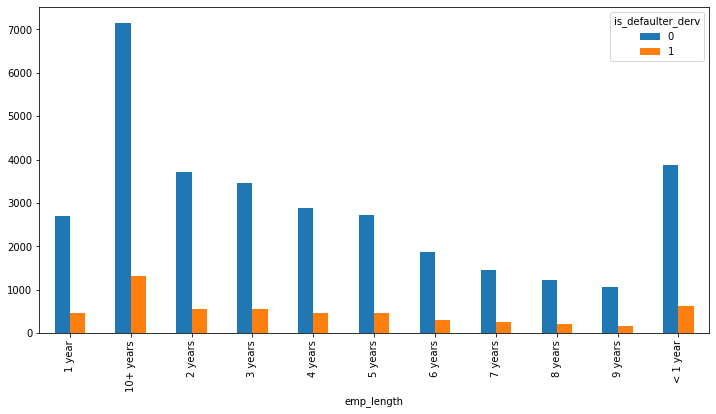

In [186]:
pd.crosstab(loan_data.emp_length,loan_data.is_defaulter_derv)\
.plot(kind='bar', figsize=ASP_RATIO);


In [187]:
perfrom_chi_2_test(loan_data,'emp_length','is_defaulter_derv')

 P_value for chi_2 test between emp_length and is_defaulter_derv 0.01


In [193]:
perfrom_chi_2_test(loan_data,'pub_rec','is_defaulter_derv')

 P_value for chi_2 test between pub_rec and is_defaulter_derv 0.0
